# Investigating how source density impacts the number of dia sources 

## Context
Inspired by the plot in DM-43074 that shows that the number of DIA source counts changes strongly with tract number, I thought I'd look at how the DIA source count in a visit/detector image relates to the number of sources in the image, since the latter is one of things that will change by a considerable amount between tracts.

As well as exploring whether there's a relation between DIA source count and total source count, I also considered "bright" sources, here defined as sources that have a 12-pixel aperture flux greater than $10^3$, $10^4$, and $10^5$ nJy. The motivation behind considering bright sources is that my limited experience of difference images suggests that residuals tend to be worse around bright sources.

In [1]:
# Standard imports:
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord

import glob as glob
import os

In [2]:
# A function to match DIA sources to "all" sources in 'initial_stars_footprints_detector'.
def MatchToSources(diaSources, allSources):
    '''
    This matches sources in a DIA source table to sources in a 
    initial_stars_footprints_detector table.

    Inputs
    ------
    diaSources: A Pandas dataframe containing DIA sources (one per row).
                The dataframe must columns headed "ra" and "dec".
    allSources: A Pandas dataframe containing all sources detected in the 
                exposure associated with the same difference image. The
                dataframe must contain columns headed "coord_ra" and 
                "coord_dec".

    Outputs
    -------
    diaSources: The diaSources dataframe but with two columns added:
                    "SepToMatch": Distance in arcseconds to the nearest
                    source in allSources.
                    "FluxOfMatch": 12-pixel aperture flux in nJy of
                    the nearest source in allSources.
                    "SNROfMatch": 12-pixel aperture signa-to-noise ration
                    of nearest sources in allSources.
    '''

    diaCoords = SkyCoord(ra=diaSources['ra'].values*u.degree, dec=diaSources['dec'].values*u.degree)
    allCoords = SkyCoord(ra=allSources['coord_ra']*u.rad, dec=allSources['coord_dec']*u.rad)

    idx, d2d, d3d = diaCoords.match_to_catalog_sky(allCoords)
    diaSources['SepToMatch'] = d2d.to(u.arcsec).value
    diaSources['FluxOfMatch'] = allSources['base_CircularApertureFlux_12_0_flux'][idx]
    diaSources['SNROfMatch'] = (
        allSources['base_CircularApertureFlux_12_0_flux'][idx] / 
        allSources['base_CircularApertureFlux_12_0_fluxErr'][idx]
    )

    return diaSources

In [3]:
# A funuction to determine the filename of a truthtable covering a DIA detecor image.
def GetTruthFiles(RA, Dec):
    '''
    Given a set of coordinates, determine the filename of the pointsource parquet
    truth table that covers that region. This is needed because the parquet files
    are named according to the htm7 nside=32 region that they cover, so the index
    of the htm7 segment is needed to identify the file.

    Note
    ----
    This calculates the mean coordinate of the catalogue and uses that to
    determine the htm7 segment.

    Inputs
    ------
    RA: Pandas series containing the Right Ascention of sources in degrees.
    Dec: Pandas series containing the Deckination of sources in degrees.

    Outputs
    -------
    truthFiles: List of filenames of the truth table parquet files that cover the
                region of interest.
    
    '''
    truthFiles = []

    mean_ra = np.deg2rad(np.mean(RA.value))
    mean_de = np.deg2rad(90. - np.mean(Dec.value))
    coordVec = hp.ang2vec(mean_de, mean_ra)
    ipix_discs = hp.query_disc(nside=32, vec=coordVec, radius=np.radians(2))

    for ipix_disc in ipix_discs:
        filename = '/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-3/imSim_catalogs/skyCatalogs/pointsource_{}.parquet'.format(ipix_disc)
        if os.path.exists(filename):
            truthFiles.append(filename)        
    return truthFiles

In [4]:
# Butler setup and skyMap retrieval:
butler = dafButler.Butler('/repo/embargo', collections='u/elhoward/DM-44138/LSSTComCamSim')
registry = butler.registry
skyMap = butler.get('skyMap', dataId={'skymap':'ops_rehersal_prep_2k_v1'})

## Get a bunch of dataset refs for goodSeeingDiff_diaSrcTable
For expediency, I'm only grabbing the data for detector 5. As you'll see later, I'm obtaining the plot data by looping over a bunch of dataset references, which is slow-ish. I believe this looping wouldn't be needed if I could query APDB, but I don't currently have access to that database, so this was the only other way I could think of doing it. 

In [5]:
# Grab all the goodSeeingDiff_diaSrcTable's for detector=5
query = (
    "instrument='LSSTComCamSim' AND "
    "skymap='ops_rehersal_prep_2k_v1' AND "
    "visit >= 7024040200000 AND "
    "visit <= 7024040500000"
)
gSDTableRefs = list(registry.queryDatasets('goodSeeingDiff_diaSrcTable', where=query))

## Determine the number of DIA sources associated with variable stars
Identify the truth tables covering each of the visit/detector combinations. The truth tables are stored on a per-(htm7, nSide=32) basis, so HEALPix is used to identify the truth table that covers the patch of sky associated with a given visit/detector. Once the truth tables are identified, a straightforward 3-arcsec positional match is performed to between the DIA sources and the truth table. If a match is found, variability information is extracted from the truth table and appended as an extra column to the DIA source table. This is then saved to /home/m/mullaney/DATA/OR3_DIATables/.

**IMPORTANT: This shouldn't be run in its unmodified form in a notebook, as it will loop over all ~20,000 OR3 DIA source tables, and takes about 5 hours to run. It's only here for reference.**

In [6]:
outDir = '/home/m/mullaney/DATA/OR3_DIATables/'
gSDTableRefs = gSDTableRefs[0:10] # Comment to process all

for gSDTableRef in gSDTableRefs:
    gSDTable = butler.get(gSDTableRef)
    gSDTable['is_variable'] = False
    gSDCoords = SkyCoord(ra=gSDTable['ra'].values*u.degree, dec=gSDTable['dec'].values*u.degree)

    for truthFile in GetTruthFiles(gSDTable['ra'].values*u.degree, gSDTable['dec'].values*u.degree):
        truthTable = pd.read_parquet(truthFile)
        truthCoords = SkyCoord(ra=truthTable['ra'].values*u.degree, dec=truthTable['dec'].values*u.degree)
        if 'is_variable' in truthTable.columns:
            isTruthVariable = truthTable['is_variable'].values
            idx, d2d, d3d = gSDCoords.match_to_catalog_sky(truthCoords)
            sep_constraint = d2d < 3.0*u.arcsec            
            isMatchVariable = isTruthVariable[idx[sep_constraint]]
            
            isDiaVariable = np.ones(len(gSDTable)) == 0 
            isDiaVariable[sep_constraint] = isMatchVariable
            gSDTable['is_variable'] += isDiaVariable
    
    outFile = outDir + 'DIASource_{}_{}_{}.parquet'.format(gSDTableRef.dataId['visit'],gSDTableRef.dataId['detector'],gSDTableRef.dataId['band'])
    #gSDTable.to_parquet(outFile) # Uncomment to write to file

## Create a summary table

Loop over every new table, extracting the total number of DIA sources, and the number of those matched to true variable sources. Then use queryDataIds get the tract covered by the visit image. Next, get the other metadata I might be interested in considering (visit, detector, band). Finally, I butler.get the corresponding initial_stars_footprints_detector table, which I understand contains the source data for the image - one row per source. I determine both the total number of sources, and the number of bright sources ($>10^3$, $>10^4$, $>10^5$ nJy).

**Important: If run without limiting the number of table references, it will loop over all 20,000 tables and take about an hour to run.**

In [7]:
NdiaSrc = []
Nvariable = []
visits = []
bands = []
detectors = []
tracts = []
Nsrc = []
Nsrc_gt_1e5 = []
Nsrc_gt_1e4 = []
Nsrc_gt_1e3 = []

DIAFiles = glob.glob('/home/m/mullaney/DATA/OR3_DIATables/*.parquet')
DIAFiles = DIAFiles[0:1] # Comment to process all

for DIAFile in DIAFiles:
    visit = int(os.path.basename(DIAFile)[10:23])
    detector = int(os.path.basename(DIAFile)[24:25])
    band = os.path.basename(DIAFile)[26:27]

    dataId = {'visit':visit, 'detector':detector, 'band':band}
    
    diaSources = pd.read_parquet(DIAFile)
    NdiaSrc.append(len(diaSources))
    Nvariable.append(np.sum(diaSources['is_variable']))
    
    tractId = list(registry.queryDataIds(["tract"], datasets='goodSeeingDiff_diaSrcTable', dataId=dataId)) 
    tracts.append(tractId[0]['tract'])
    visits.append(visit)
    detectors.append(detector)
    bands.append(band)

    srcTable = butler.get('initial_stars_footprints_detector', dataId=dataId)
    Nsrc.append(len(srcTable))
    Nsrc_gt_1e5.append(np.sum(srcTable['base_CircularApertureFlux_12_0_flux'] > 1e5))
    Nsrc_gt_1e4.append(np.sum(srcTable['base_CircularApertureFlux_12_0_flux'] > 1e4))
    Nsrc_gt_1e3.append(np.sum(srcTable['base_CircularApertureFlux_12_0_flux'] > 1e3))
    diaTable = butler.get('goodSeeingDiff_diaSrcTable', dataId=dataId)

df = pd.DataFrame({
    "visit":visits,
    "band":bands,
    "detector":detectors,
    "tract":tracts,
    "N_DIASources":NdiaSrc,
    "N_VariableMatches": Nvariable,
    "N_Sources":Nsrc,
    "N_Sources_gt_1e3nJy":Nsrc_gt_1e3,
    "N_Sources_gt_1e4nJy":Nsrc_gt_1e4,
    "N_Sources_gt_1e5nJy":Nsrc_gt_1e5
})
#df.to_parquet('~/DATA/OR3_DIATables/000_DIASummaryTable.parquet') # Uncomment to write to file

## And make some plots:

### Plots of number of DIA sources vs. number of "bright" sources.
The one row per band (see plot title) and one column per brightness cut ($>10^3$, $>10^4$, $>10^5$; see x-axis label). The line simply shows a one-to-one line, scaled up or down to that it passes through the mean of the points. There are are nine points per visit - one per simulated ComCam detector.

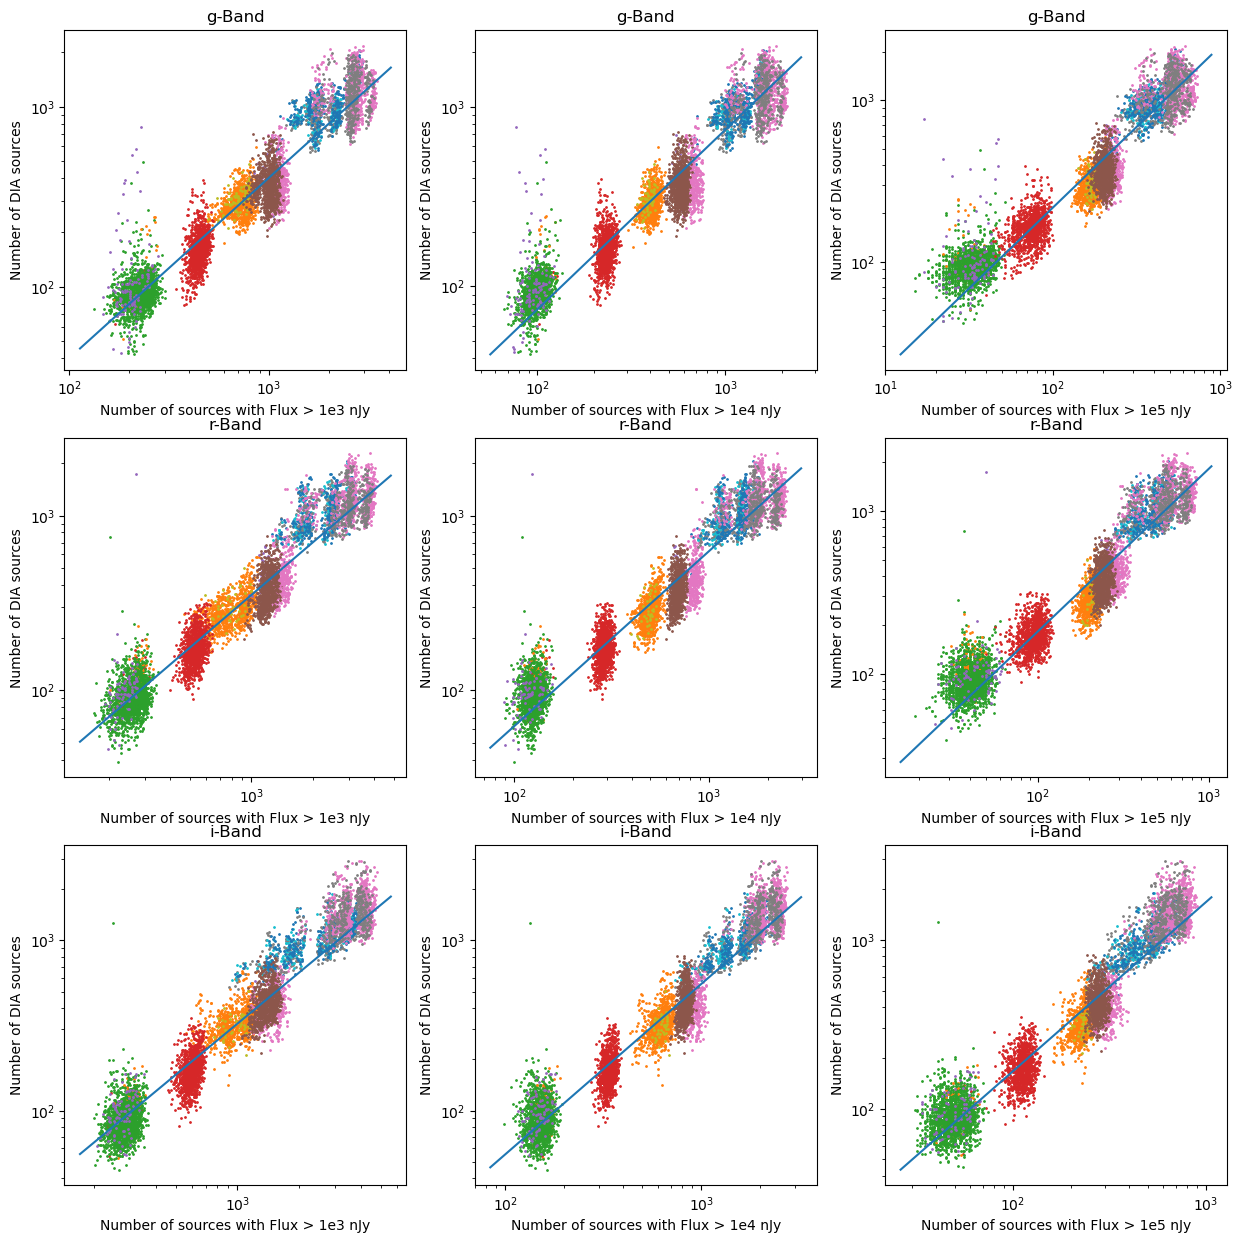

In [8]:
df = pd.read_csv('/home/m/mullaney/DATA/OR3_DIATables/000_DIASummaryTable.parquet')
uniqTracts = set(df['tract'])

fig, axes = plt.subplots(3,3, figsize=(15, 15))

for j, cut in enumerate(['1e3','1e4','1e5']):
    for i, band in enumerate(['g', 'r', 'i']): 
        perBand = df.loc[df['band'] == band]

        for uniqTract in uniqTracts:
            mask = perBand['tract'] == uniqTract
            axes[i,j].scatter(perBand["N_Sources_gt_{}nJy".format(cut)][mask],
                              perBand["N_DIASources"][mask],
                              s=1., label=str(uniqTract))
        meanRatio = np.mean(
            perBand["N_Sources_gt_{}nJy".format(cut)] / perBand["N_DIASources"]
        )
        axes[i,j].set_title('{}-Band'.format(band))
        axes[i,j].set_xscale('log')
        axes[i,j].set_yscale('log')
        axes[i,j].set_xlabel('Number of sources with Flux > {} nJy'.format(cut))
        axes[i,j].set_ylabel('Number of DIA sources')
        xlims = axes[i,j].get_xlim()
        axes[i,j].plot(xlims, np.array(xlims) / meanRatio)


### Plot of (Flux of) vs. (Separation to) the nearest matched source.

Given the strong correlation between the numbers of DIA sources and the number of bright sources in an exposure, let's dive into this a little more. Firstly, however, since around $10%$ of all stars in an image are variable, and thus potentially "true" difference sources, it is important that we first account for these by matching to the truth tables.

The plots below show the relationship between DIA sources and sources detected in the corresponding exposure. These detections are following an initial sources detection algorithm that has been run on the exposure, which has a high detection threshold and tends to rejects blends. Since there are around 20,000 difference images in OR3, only three - chosen largely at random - are shown here. Having said that, having looked at a number of these plots, the three shown are fairly representative of the vast majority.

In each plot, DIA sources associated with variable (blue) and non-variable (orange) are shown saparately. This variability information is taken from the truth tables but, to reiterate, the separations and fluxes are from the initial analysis of the _exposures_.

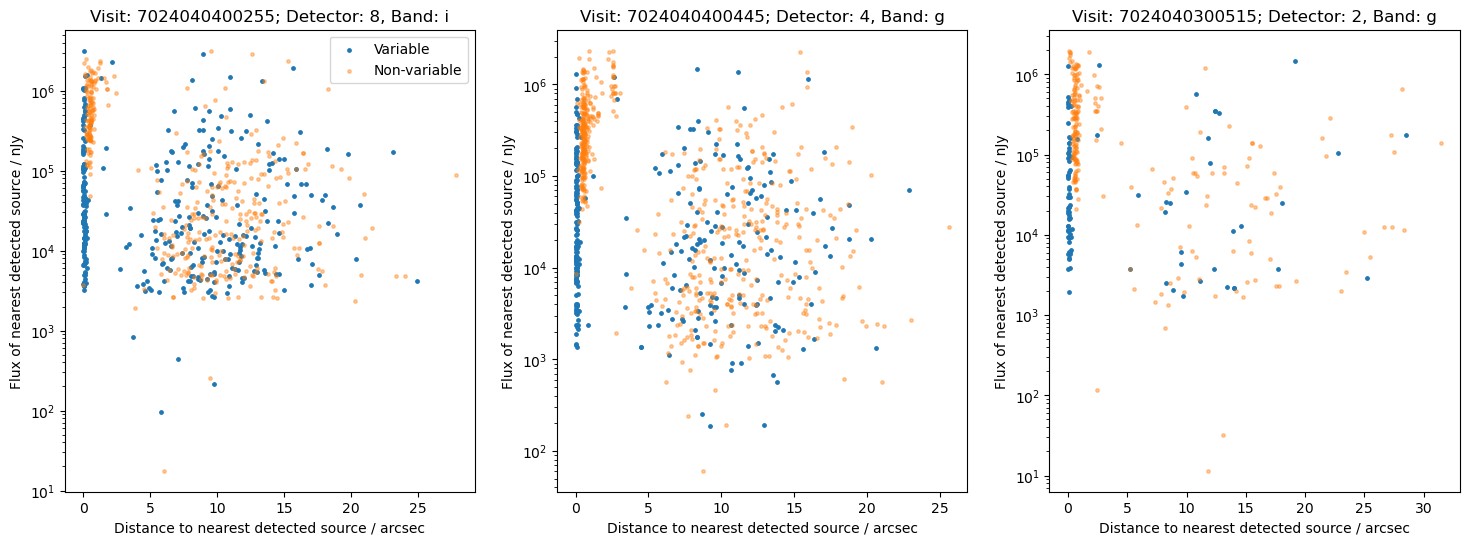

In [9]:
files = glob.glob('/home/m/mullaney/DATA/OR3_DIATables/*.parquet')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

indices = [1000, 1800, 2769]
for i, index in enumerate(indices):
    
    visit = int(os.path.basename(files[index])[10:23])
    detector = int(os.path.basename(files[index])[24:25])
    band = os.path.basename(files[index])[26:27]

    dataId={'visit':visit, 'detector':detector, 'band':band}
    
    diaSources = pd.read_parquet(files[index])
    allSources = butler.get('initial_stars_footprints_detector', dataId=dataId)
    matchedDiaSources = MatchToSources(diaSources, allSources)
    
    mask = matchedDiaSources['is_variable']
    axes[i].scatter(matchedDiaSources['SepToMatch'][mask], matchedDiaSources['FluxOfMatch'][mask], label='Variable', s=6.0, alpha=1.0)
    axes[i].scatter(matchedDiaSources['SepToMatch'][~mask], matchedDiaSources['FluxOfMatch'][~mask], label='Non-variable', s=6.0, alpha=0.4)

    axes[i].set_yscale('log')
    axes[i].set_xlabel('Distance to nearest detected source / arcsec')
    axes[i].set_ylabel('Flux of nearest detected source / nJy')
    axes[i].set_title('Visit: {}; Detector: {}, Band: {}'.format(visit,detector,band))
    if i==0:
        axes[i].legend()

There are three of four general "clusters" of points in each of these images, depending on how one defines a cluster. Firstly, there is the line of blue points at almost zero separation. These represent DIA sources which are flagged as variable -- through the match to the truth table -- and are matched to a very close (typically $<1$ arcsec) source in the exposure image. This blue line of points covers the full dynamic range of the detected source fluxes. Secondly, there is the slightly thicker line of orange points, again at small separations. These represent DIA sources that are not flagged as variable -- again, through the match to the truth table. These are typically at the bright end of the flux distributions. Finally, there is the "cloud" of both variable and non-variable flagged sources that have large separations (typically $>5$ arcec) from their nearest detected source. These cover the full dynamic range of the source flux distribution.

### Where does each cluster sit on a diffIm and exposure?
The points with small separations make sense: either the mostly "true positives" blue points ("mostly" because it's possible that some of them have been caught because their bright, not because they have variaed substantially), or the "false-positives" associated with very bright sources. The "cloud" makes less sense, so I thought I'd take a look where they sit on the difference image and exposure in relation to detected sources. The following does this for a single frame, opening up a FireFly viewer...

In [10]:
# Take the visit/detector asscociated with the middle plot above
# And re-match to the source catalogue (since this information
# was lost in the for-loop).
index = 1800

visit = int(os.path.basename(files[index])[10:23])
detector = int(os.path.basename(files[index])[24:25])
band = os.path.basename(files[index])[26:27]
dataId={'visit':visit, 'detector':detector, 'band':band}

diaSources = pd.read_parquet(files[index])
allSources = butler.get('initial_stars_footprints_detector', dataId=dataId)

matchedDiaSources = MatchToSources(diaSources, allSources)
##########

#Display the difference image and exposure in firefly:
afwDisplay.setDefaultBackend('firefly')

afw_display = afwDisplay.Display(frame=1)
diffExp = butler.get('goodSeeingDiff_differenceExp', dataId=dataId)
afw_display.mtv(diffExp)

afw_display = afwDisplay.Display(frame=2)
calExp = butler.get('initial_pvi', dataId=dataId)
afw_display.mtv(calExp)

# And plot on the various types of sources:
afw_display = afwDisplay.Display(frame=1)
afw_display.erase()
with afw_display.Buffering():
    for i, matchedDiaSource in matchedDiaSources.iterrows():
        if matchedDiaSource['is_variable']:
            if matchedDiaSource['SepToMatch'] > 3.:
                color='cyan'
            else:
                color='blue'
        if not matchedDiaSource['is_variable']:
            if matchedDiaSource['SepToMatch'] > 3.:
                color='orange'
            else:
                color='red'
        afw_display.dot('o', matchedDiaSource['x'], matchedDiaSource['y'], size=20, ctype=color)
    for source in allSources:
        afw_display.dot('x', source.getX(), source.getY(), size=10, ctype='red')

afw_display = afwDisplay.Display(frame=2)
afw_display.erase()
with afw_display.Buffering():
    for source in allSources:
        afw_display.dot('x', source.getX(), source.getY(), size=10, ctype='red')

In those images, DIA sources are shown as coloured circles (blue = variable, matched to a source; cyan = variable, not matched to a source; red = non-variable, matched to a source; orange = non-variable, not matched to a source). It's clear that many of the non-matches sources (cyan and orange) are, in fact, associated with a source, but that a record of this source is not included in the source table produced by the initial analysis. These are typically low ($<10$) SNR sources, or blends.

So, "cloud" sources are primarily DIA sources -- variable or not -- which _are_ associated with sources, but not sources that were detected in the initial analysis.

### Plots of (Flux of) vs. (Separation to) truth sources

Since the source catalogue is not comprehensive enough to contain all sources associated with a DIA source, it was suggested that I do the same exercise but instead showing the flux of and distance to the nearest match in the truth catalogue. This is shown below for the same three cases as above. Note that since the truth catalog records fluxes in magnitudes, the y-axis is in mags, rather tham nJy as above, but the axis is reversed so that "brighter" is still "higher".

Connection to remote host was lost.


'NoneType' object has no attribute 'handshake_response'


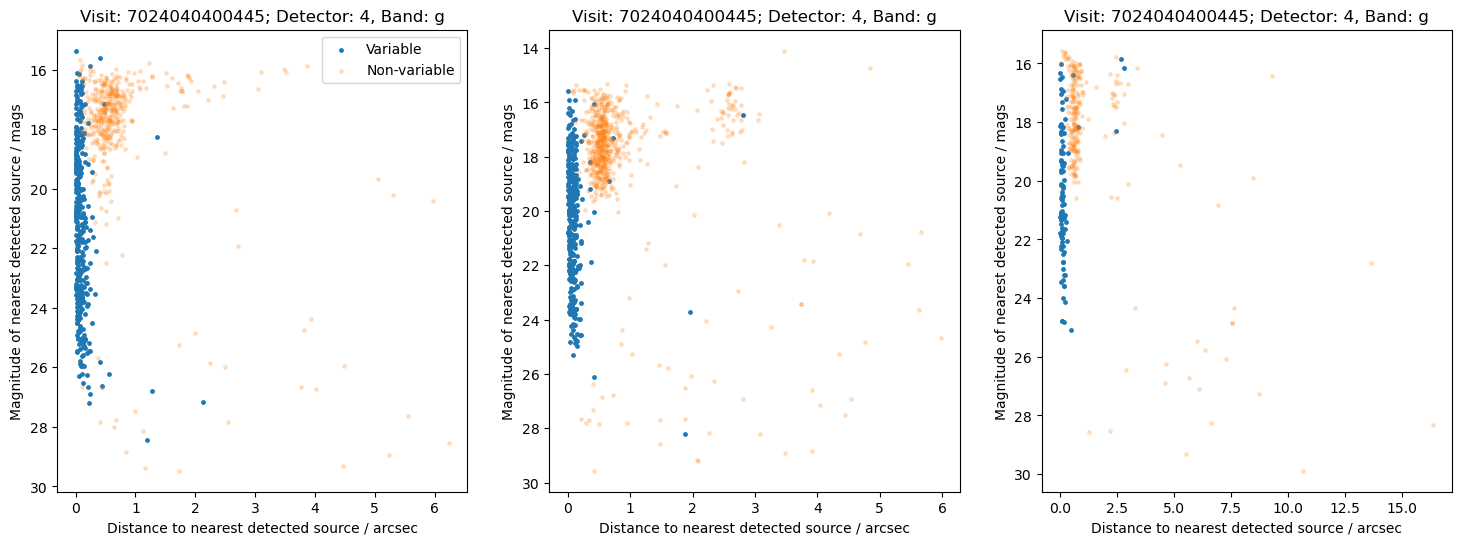

In [11]:
files = glob.glob('/home/m/mullaney/DATA/OR3_DIATables/*.parquet')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

indices = [1000, 1800, 2769]
for i, index in enumerate(indices):
        
    diaSources = pd.read_parquet(files[index])
    sepToTruth = np.ones(len(diaSources)) * 3600
    fluxOfTruth = np.ones(len(diaSources)) * -99
    
    diaCoords = SkyCoord(ra=diaSources['ra'].values*u.degree, dec=diaSources['dec'].values*u.degree)
    
    for truthFile in GetTruthFiles(diaSources['ra'].values*u.degree, diaSources['dec'].values*u.degree):
        truthTable = pd.read_parquet(truthFile)
        truthCoords = SkyCoord(ra=truthTable['ra'].values*u.degree, dec=truthTable['dec'].values*u.degree)

        idx, d2d, d3d = diaCoords.match_to_catalog_sky(truthCoords)
        betterMatch = d2d.to(u.arcsec).value < sepToTruth
        sepToTruth[betterMatch] = d2d.to(u.arcsec).value[betterMatch]
        fluxOfTruth[betterMatch] = truthTable['magnorm'][idx[betterMatch]]
        
    mask = diaSources['is_variable']
    axes[i].scatter(sepToTruth[mask], fluxOfTruth[mask], label='Variable', s=6.0, alpha=1.0)
    axes[i].scatter(sepToTruth[~mask], fluxOfTruth[~mask], label='Non-variable', s=6.0, alpha=0.2)
    axes[i].invert_yaxis()
    axes[i].set_xlabel('Distance to nearest detected source / arcsec')
    axes[i].set_ylabel('Magnitude of nearest detected source / mags')
    axes[i].set_title('Visit: {}; Detector: {}, Band: {}'.format(visit,detector,band))
    if i==0:
        axes[i].legend()

It is clear that the "cloud" has _mostly_ disappeared, with those sources previously within the cloud joining the small-separation "lines" (note the range of the x-axis has become much smaller for the leftmost and central plots). There remains some points at large separations, and these warrant further investigation, but these are now a small minority of DIA sources. It is interesting that there are clusters of sources now at $~2.5$ arcsec separations from very bright sources. Are these detections associated with, perhaps, diffraction spikes? 

### Plots of (SN of) vs. (Separation to) the nearest matched source

With the source of the "cloud" mostly cleared-up, a further thing to consider is relationship to high signal-to-noise sources, which is shown below:

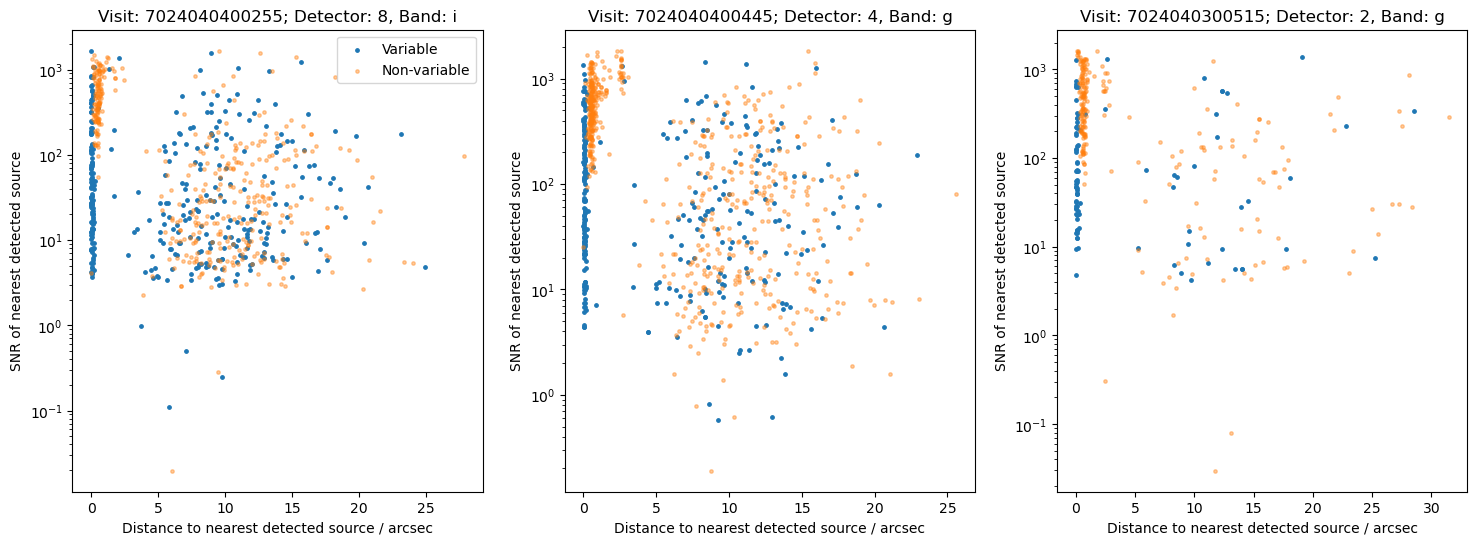

In [12]:
files = glob.glob('/home/m/mullaney/DATA/OR3_DIATables/*.parquet')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

indices = [1000, 1800, 2769]
for i, index in enumerate(indices):
    
    visit = int(os.path.basename(files[index])[10:23])
    detector = int(os.path.basename(files[index])[24:25])
    band = os.path.basename(files[index])[26:27]

    dataId={'visit':visit, 'detector':detector, 'band':band}
    
    diaSources = pd.read_parquet(files[index])
    allSources = butler.get('initial_stars_footprints_detector', dataId=dataId)
    matchedDiaSources = MatchToSources(diaSources, allSources)
    
    mask = matchedDiaSources['is_variable']
    axes[i].scatter(matchedDiaSources['SepToMatch'][mask], matchedDiaSources['SNROfMatch'][mask], label='Variable', s=6.0, alpha=1.0)
    axes[i].scatter(matchedDiaSources['SepToMatch'][~mask], matchedDiaSources['SNROfMatch'][~mask], label='Non-variable', s=6.0, alpha=0.4)

    axes[i].set_yscale('log')
    axes[i].set_xlabel('Distance to nearest detected source / arcsec')
    axes[i].set_ylabel('SNR of nearest detected source')
    axes[i].set_title('Visit: {}; Detector: {}, Band: {}'.format(visit,detector,band))
    if i==0:
        axes[i].legend()

Somewhat unsurprisingly, given that the exposures in the simulated dataset have the same exposure times and similar "observing conditions", the SNR plots are very similar to the flux plots above.

### Plots of number of "false" DIA sources vs. number of "bright" sources.

Given that a significant number of the DIA sources are associated with truly variable sources, it is worthwhile exploring how the numbers of false-positive DIA sources per difference image changes with the number of bright sources per exposure. Below you will find an equivalent plot to the _Plots of number of "false" DIA sources vs. number of "bright" sources_ shown above, but this time the number of DIA sources (on the y-axis) _excludes_ true positives. As such, this gives an indication of how the numbers of false positives increases with the number of bright sources in an images. If anything, it seems that the correlation -- while still obviously present -- has somewhat more scatter. This is probably to be expected given the constant (i.e., $~10%$) fraction of truth-table point sources that are variable (i.e., taken to the extreme, if _all_ point sources were variable, then there would be an almost perfect correlation; an increasing fraction "tightens" the correlation). 

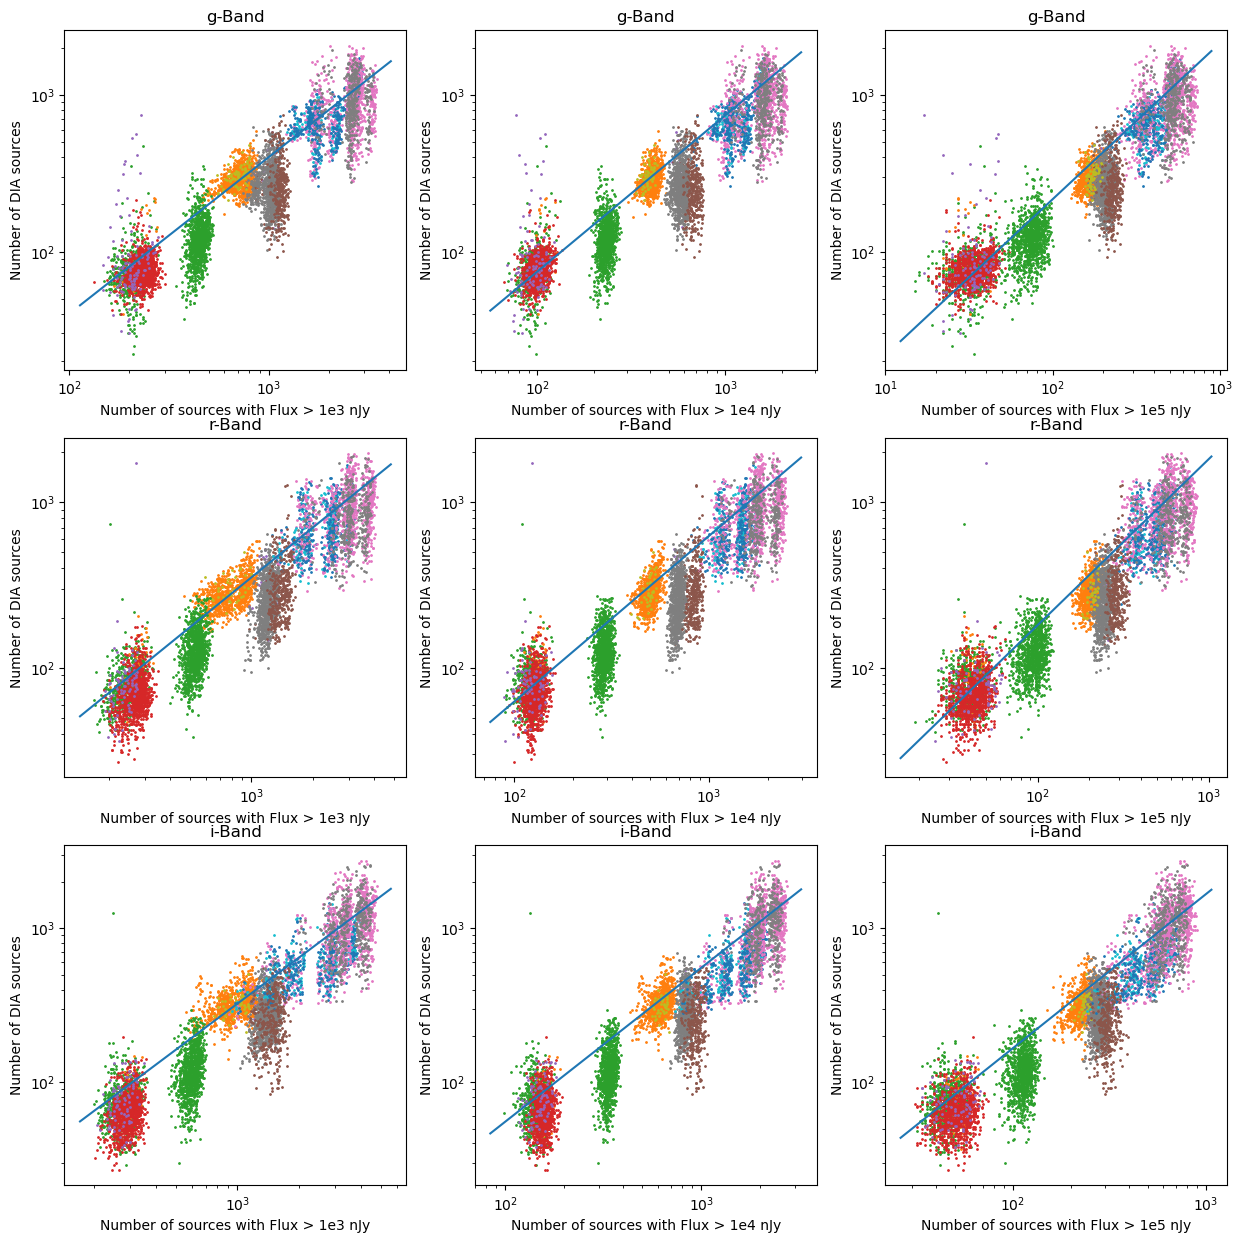

In [14]:
df = pd.read_parquet('/home/m/mullaney/DATA/OR3_DIATables/000_DIASummaryTable.parquet')
uniqTracts = set(df['tract'])

fig, axes = plt.subplots(3,3, figsize=(15, 15))

for j, cut in enumerate(['1e3','1e4','1e5']):
    for i, band in enumerate(['g', 'r', 'i']): 
        perBand = df.loc[df['band'] == band]

        for uniqTract in uniqTracts:
            mask = perBand['tract'] == uniqTract
            axes[i,j].scatter(perBand["N_Sources_gt_{}nJy".format(cut)][mask],
                              perBand["N_DIASources"][mask] - perBand["N_VariableMatches"][mask],
                              s=1., label=str(uniqTract))
        meanRatio = np.mean(
            perBand["N_Sources_gt_{}nJy".format(cut)] / perBand["N_DIASources"]
        )
        axes[i,j].set_title('{}-Band'.format(band))
        axes[i,j].set_xscale('log')
        axes[i,j].set_yscale('log')
        axes[i,j].set_xlabel('Number of sources with Flux > {} nJy'.format(cut))
        axes[i,j].set_ylabel('Number of DIA sources')
        xlims = axes[i,j].get_xlim()
        axes[i,j].plot(xlims, np.array(xlims) / meanRatio)
